# MultiBody tutorial

In this notebook we will see what compose a MultiBody and how to create it.

A MultiBody is a list of rigid bodies linked together by joints. We use it to represent a robot.
The [RBDyn](https://github.com/jorisv/RBDyn) library support kinematic tree and kinematic chain, but don't support closed loop kinematic structure. This last structure is addressed at a higher level in the [Tasks](https://github.com/jorisv/Tasks) library.

In this tutorial we will see first the [Body](#Body) and [Joint](#Joint) class that represent respectively link inertia and articulation type.

Then the [MultiBodyGraph](#MultiBodyGraph) class will be quickly introduced. This important class allow to store an abstract representation of the robot. We will see this class in depth in a next tutorial.

Finally we will show the [MultiBody](#MultiBody) and the [MultiBodyConfig](#MultiBodyConfig) class. The first one is a compact representation of a robot, while the second hold state value of the robot and algorithm results (articulated configuration, body configuration, external force applied on each body...)

In [1]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

display_number = 1
def display():
    global display_number
    path = 'img/SpaceVecAlg/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

In [2]:
import numpy as np
import eigen3 as e
import spacevecalg as sva
import rbdyn as rbd

## Body

`rbd::Body` is a simple class that store a body name, id and inertia.

The body name must be an unique string value associated with the body.
Same for the id, that is an unique positive integer value associated with the body.

In python we will commonly use name to reference a body while the RBDyn API use id.

Finally the body store a `sva::RBInertia` class that will hold the body inertia value (mass, center of mass and rotational inertia at body origin).

In [3]:
b0m = 2. # 2kg
b0c = e.Vector3d(0.5, 0.5, 0.) # center of mass at [0.5, 0.5, 0.] from the body origin
b0rI = e.Matrix3d.Identity() # rotational inertia at body origin
# here the second argument is the body first moment of mass (h = m c)
b0I = sva.RBInertia(b0m, b0m*b0c, b0rI)
# first body constructor that take sva.RBInertia as firt param
b0 = rbd.Body(b0I, 0, 'b0')

b1m = 4. # 4kg
b1c = e.Vector3d(0., 0.5, 0.) # center of mass at [0., 0.5, 0.] from the body origin
b1rI = e.Matrix3d.Identity() # rotational inertia at body origin
# here the second argument is the body center of mass (not the first moment of mass)
b1 = rbd.Body(b1m, b1c, b1rI, 1, 'b1')

b2 = rbd.Body(1., e.Vector3d.Zero(), e.Matrix3d.Identity(), 2, 'b2')
b3 = rbd.Body(1., e.Vector3d.Zero(), e.Matrix3d.Identity(), 3, 'b3')
b4 = rbd.Body(1., e.Vector3d.Zero(), e.Matrix3d.Identity(), 4, 'b4')
b5 = rbd.Body(1., e.Vector3d.Zero(), e.Matrix3d.Identity(), 5, 'b5')

## Joint

The `rbd::Joint` class is more complex than `rbd::Body` especially because this class old 7 kind of joint:
 * [Fixed](#Fixed) : Fixed joint
 * [Revolute](#Revolute) : Rotate around one axis
 * [Prismatic](#Prismatic) : Translate on one axis
 * [Spherical](#Spherical) : Spherical rotation
 * [Planar](#Planar) : Rotation around the normal axis and translation on the tangent plan
 * [Cylindrical](#Cylindrical) : Rotation and translation around one axis
 * [Free](#Free) : 6DoF transformation
 
In a first time we will see common Joint methods, then we will see the particularity of each joint type.
 
Like Body, each Joint should have an unique string and positive integer Id.
Joint also have a forward attribute. If this attribute is false the polarity of the joint is reversed, that mean transformation and motion vector return by the joint will be inversed.
Also some joint type can take an axis as parameter.

Two constructor exist:
```c++
Joint(Type type, const Eigen::Vector3d& axis, bool forward, int id, std::string name)
Joint(Type type, bool forward, int id, std::string name)
```

Each Joint have a number of parameters `int params() const` ($ P $) and a number of degree of freedom (DoF) `int dof() const` ($ A $). Those value give the size of the articulated position vector $ q_i \in \mathbb{R}^{P} $ and the articulated velocity vector $ \alpha_i \in \mathbb{R}^{A} $ of the joint $ i $.
The articulated velocity vector is for all joint expressed in the successor frame of the joint, that mean in the frame after the transformation of the joint.

The `Eigen::MatrixXd motionSubspace() const` method return the Motion Subspace matrix $ S \in \mathbb{R}^{6,A} $ that allow to transform the articulated position vector and all his time derivative into a motion vector $ \hat{v}_i = S_i \alpha_i $. In this implementation all Motion Subspace matrix are constant and don't depend of the Joint configuration.

The `sva::PTransformd pose(const std::vector<double>& q) const` return the transformation of a joint associated to a articulated position vector $ q_i $.

The `sva::MotionVecd motion(const std::vector<double>& alpha) const` return the motion vector of a joint associated to a articulation velocity vector and his all his time derivative $ \alpha_i $.

Finally the `std::vector<double> zeroParam() const` and `std::vector<double> zeroDof() const` return the articulated position vector $ q_i $ and articulated velocity vector $ \alpha_i $ that produce respectively an identity transform and a null motion vector.

In [4]:
def jointResume(j):
    print 'P =', j.params()
    print 'A =', j.dof()
    print 'qZero =', list(j.zeroParam())
    print 'alphaZero =', list(j.zeroDof())
    print 'motion subspace ='
    print e.toNumpy(j.motionSubspace())

### Fixed

The fixed joint don't take any parameter and have zero degree of freedom.

In [5]:
jFix = rbd.Joint(rbd.Joint.Fixed, True, 0, 'jFix')
jointResume(jFix)

P = 0
A = 0
qZero = []
alphaZero = []
motion subspace =
[]


### Revolute

The revolute joint rotate around one axis given in parameter and have 1 parameter and 1 degree of freedom.

In [6]:
# Revolute joint around X axis
jRev = rbd.Joint(rbd.Joint.Rev, e.Vector3d.UnitX(), True, 0, 'jRev')
jointResume(jRev)
print 'rotation:'
print jRev.pose([np.pi/2.]).rotation()
print 'angular motion:', jRev.motion([1.]).angular().transpose()

P = 1
A = 1
qZero = [0.0]
alphaZero = [0.0]
motion subspace =
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
rotation:
          1           0           0
          0 6.12323e-17           1
          0          -1 6.12323e-17
angular motion: 1 0 0


### Prismatic

The prismatic joint translate around one axis given in parameter and have 1 parameter and 1 degree of freedom.

In [7]:
# Prismatic joint at Y axis
jPrism = rbd.Joint(rbd.Joint.Prism, e.Vector3d.UnitY(), True, 0, 'jPrism')
jointResume(jPrism)
print 'translation:', jPrism.pose([1.]).translation().transpose()
print 'linear motion:', jPrism.motion([0.1]).linear().transpose()

P = 1
A = 1
qZero = [0.0]
alphaZero = [0.0]
motion subspace =
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]]
translation: 0 1 0
linear motion:   0 0.1   0


### Spherical

The sphercial joint is a particular one. It use an unit quaternion (qw, qx, qy, qz) to encode a 3D rotation. Because of the quaternion this joint have 4 parameters [qw, qx, qy, qz] and 3 degree of freedom [wx, wy, wz].

In [8]:
jSph = rbd.Joint(rbd.Joint.Spherical, True, 0, 'jSph')
jointResume(jSph)
q = e.Quaterniond(np.pi/4., e.Vector3d(1., 0., 0.5).normalized())
qParam = [q.w(), q.x(), q.y(), q.z()]
print 'rotation:'
print jSph.pose(qParam).rotation()
print 'angular motion:', jSph.motion([1., 0.2, 0.5]).angular().transpose()

P = 4
A = 3
qZero = [1.0, 0.0, 0.0, 0.0]
alphaZero = [0.0, 0.0, 0.0]
motion subspace =
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
rotation:
 0.941421  0.316228  0.117157
-0.316228  0.707107  0.632456
 0.117157 -0.632456  0.765685
angular motion:   1 0.2 0.5


### Planar

The planar joint rotate around the normal axis (Z) and translate around the tangent plane (X,Y) AFTER the rotation.
That mean the rotation is done first, then the translation is done in the rotated frame.
This joint take 3 parameters [rotation_Z, translation_X, translation_Y] and have 3 degree of freedom in the same order.

In [9]:
jPlan = rbd.Joint(rbd.Joint.Planar, True, 0, 'jPlan')
jointResume(jPlan)
qParam = [np.pi/2., 0.2, 0.1]
print 'translation:', jPlan.pose(qParam).translation().transpose()
print 'rotation:'
print jPlan.pose(qParam).rotation()
print 'motion:', jPlan.motion([0.2, 0.5, -0.5])

P = 3
A = 3
qZero = [0.0, 0.0, 0.0]
alphaZero = [0.0, 0.0, 0.0]
motion subspace =
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
translation: -0.1 0.2   0
rotation:
6.12323e-17           1           0
         -1 6.12323e-17           0
          0           0           1
motion:    0    0  0.2  0.5 -0.5    0


### Cylindrical

The cylindrical joint translate around one axis and then rotation around the same axis.
It take 2 parameters [rotation_axis, translation_axis] and 2 degree of freedom in the same order.

In [10]:
jCyl = rbd.Joint(rbd.Joint.Cylindrical, e.Vector3d.UnitZ(), True, 0, 'jCyl')
jointResume(jCyl)
qParam = [np.pi/2., 0.4]
print 'translation:', jCyl.pose(qParam).translation().transpose()
print 'rotation:'
print jCyl.pose(qParam).rotation()
print 'motion:', jCyl.motion([0.4, -0.7])

P = 2
A = 2
qZero = [0.0, 0.0]
alphaZero = [0.0, 0.0]
motion subspace =
[[ 0.  0.]
 [ 0.  0.]
 [ 1.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  1.]]
translation:   0   0 0.4
rotation:
6.12323e-17           1           0
         -1 6.12323e-17           0
          0           0           1
motion:    0    0  0.4    0    0 -0.7


### Free

The free joint is a 6Dof transformation. It make a 3d translation and a 3d rotation.
Like the spherical joint, the free joint use an unit quaternion for rotation that make this joint have don't have the same number of parameters and degree of freedom.

This joint have 7 parameters [qw, qx, qy, qz, tx, ty, tz] and 6 degree of freedom [wx, wy, wz, vx, vy, vz].

In [11]:
jFree = rbd.Joint(rbd.Joint.Free, True, 0, 'jFree')
jointResume(jFree)
q = e.Quaterniond(-np.pi/3., e.Vector3d(0.5, 1., 0.2).normalized())
qParam = [q.w(), q.x(), q.y(), q.z(), 0.2, -0.4, 0.7]
print 'translation:', jFree.pose(qParam).translation().transpose()
print 'rotation:'
print jFree.pose(qParam).rotation()
print 'motion:', jFree.motion([0.3, -0.2, 0.1, 1., 2.5, -3.])

P = 7
A = 6
qZero = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
alphaZero = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
motion subspace =
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]
translation:  0.2 -0.4  0.7
rotation:
 0.596899 0.0412999  0.801253
 0.346297  0.887597 -0.303727
-0.723733  0.458766  0.515504
motion:  0.3 -0.2  0.1    1  2.5   -3


## MultiBodyGraph

The `rbd::MultiBodyGraph` class use a graph to store a MultiBody.
This representation will allow to generate easily a `rbd::MultiBody` and use every body has root. It allow also to make some manipulation on the MultiBody like merging bodies or removing joints.

In this section we will only focus on how fill a `rbd::MultiBodyGraph` and generate a `rbd::MultiBody` from it.
Advanced use of `rbd::MultiBodyGraph` will be seen in a futur tutorial.

`rbd::MultiBodyGraph` have the `addBody(rbd::Body)` and `addJoint(rbd::Joint)` method that allow to add a `rbd::Body` and a `rbd::Joint` to the graph. This method will throw an exception if the body or the joint name or id already exist or is not valid.

Then we can link body together with the `linkBodies` method:
```c++
void linkBodies(int b1Id, const sva::PTransformd& tB1,
		        int b2Id, const sva::PTransformd& tB2, int jointId, bool isB1toB2=true);
```
Here `b1Id` and `b2Id` is the body integer id of the two bodies that must be linked.
`jointId` is the joint integer id of the joint that will be used to link the bodies `b1Id` and `b2Id`.
`tB1` is the static transform from the origin of the body `b1Id` to the origin of the joint `jointId`.
`tB2` is a static transform that should not be used anymore, the best is to always put it at identity.
Finally `isB1toB2` will manage the joint direction (polarity), here the best is to keep this value to true.
This method will throw an exception if one of the bodies id or joint id don't exist.

If you don't like using integer id the methods `jointIdByName` and `bodyIdByName` return the integer id from the string id of a body or a joint.

Finally, we can generate a `rbd::MultiBody` from `rbd::MultiBodyGraph` with the `makeMultiBody` method.
This method exist in 3 different flavor:
```c++
MultiBody makeMultiBody(int rootBodyId, bool isFixed,
	                	const sva::PTransformd& X_0_j0=sva::PTransformd::Identity(),
	                	const sva::PTransformd& X_b0_j0=sva::PTransformd::Identity());

MultiBody makeMultiBody(int rootBodyId, Joint::Type rootJointType,
		                const sva::PTransformd& X_0_j0=sva::PTransformd::Identity(),
		                const sva::PTransformd& X_b0_j0=sva::PTransformd::Identity());

MultiBody makeMultiBody(int rootBodyId, Joint::Type rootJointType,
		                const Eigen::Vector3d& axis,
		                const sva::PTransformd& X_0_j0=sva::PTransformd::Identity(),
		                const sva::PTransformd& X_b0_j0=sva::PTransformd::Identity());
```
The only difference between those method is the way to create the base joint.
All take the `rootBodyId` as first argument. This id will allow the algorithm to know which body will be the base of our kinematic tree (or chain).
The nexts arguments will select the root joint type and transformation:
 * `isFixed`: if true the root joint is Fixed, else the joint is Free
 * `rootJointType`: manualy specify the root joint type
 * `axis`: manualy specify the root joint axis
 * `X_0_j0`: static transformation that support the root joint
 
`X_b0_j0` is an advanced argument that will not be explain in this tutorial.

The root joint will have the special integer id $-1$ and the name "Root".

`makeMultiBody` will throw an exception if the `rootBodyId` don't exist. If you have set a cylcle in your MultiBodyGraph the behavior is undefined.

OK, enought talking, let's create our first MultiBodyGraph and ou first MultiBody.

In [12]:
mbg = rbd.MultiBodyGraph()

# first we add all the bodies previously created
mbg.addBody(b0)
mbg.addBody(b1)
mbg.addBody(b2)
mbg.addBody(b3)
mbg.addBody(b4)
mbg.addBody(b5)

# create and add joints

# revolute joint around the X axis
j0 = rbd.Joint(rbd.Joint.Rev, e.Vector3d.UnitX(), True, 0, "j0")
# revolute joint around the Y axis
j1 = rbd.Joint(rbd.Joint.Rev, e.Vector3d.UnitY(), True, 1, "j1")
# revolute joint around the Z axis
j2 = rbd.Joint(rbd.Joint.Rev, e.Vector3d.UnitZ(), True, 2, "j2")
# spherical joint
j3 = rbd.Joint(rbd.Joint.Spherical, True, 3, "j3")
# prismatic joint on the Y axis
j4 = rbd.Joint(rbd.Joint.Prism, e.Vector3d.UnitY(), True, 4, "j4")

mbg.addJoint(j0)
mbg.addJoint(j1)
mbg.addJoint(j2)
mbg.addJoint(j3)
mbg.addJoint(j4)

# Link the bodies to have this tree structure

#           b4
#        j3 | Spherical
#      j0   |   j1     j2     j4
#  b0 ---- b1 ---- b2 ----b3 ----b5
#     RevX   RevY    RevZ   PrismZ
                                                            
to = sva.PTransformd(e.Vector3d(0., 0.5, 0.))
fro = sva.PTransformd.Identity()
   
# link b0 to b1 with j0
mbg.linkBodies(0, to, 1, fro, 0)
# link b1 to b2 with j1
mbg.linkBodies(1, to, 2, fro, 1)
# link b2 to b3 with j2
mbg.linkBodies(2, to, 3, fro, 2)
# link b1 to b4 with j3
mbg.linkBodies(1, sva.PTransformd(e.Vector3d(0.5, 0., 0.)),
               4, fro, 3)
# link b3 to b5 with j4
mbg.linkBodies(3, to, 5, fro, 4)

# create the MultiBody with a fixed base and b0 has root
mb = mbg.makeMultiBody(0, True)

## MultiBody

Now we have a `rbd::MultiBody`. This class is a compact representation of the kinematics tree.
Now all our `rbd::Body`, `rbd::Joint` and the static transform list that connect them are stored in a `vector`.
The order of the bodies and joints in this vector are dependent of the root body choose when creating the MultiBody.

With the `rbd::MultiBodyGraph` we use id (integer or string) to identify a particular Body or Joint.
Here we will use an index. This index will give us the position of a Body, Joint in a `vector`.

The methods `jointIndexById` and `bodyIndexById`  allow to easily find the index of a joint and a body with their integer id.
Beware that the joint and body index only hold for one MultiBody. If you regenerate a MultiBody from a different root the index associated to a particular Joint/Body id will change.

A `rbd::MultiBody` have the followings vectors:
 * `std::vector<Body> bodies()` is a list of body.

 * `std::vector<Joint> joints()` is a list of joint. The joint $ i $ of this list support the body $ i $. That mean the joint $ i $ is connected to the base of the body $ i $.

 * `std::vector<int> predecessors()` is a list of index. The entry $ i $ of this list give the index of the body that support the joint $ i $. the index value is $ -1 $ if $ i = 0 $ (i.e. the root joint).

 * `std::vector<int> successors()` is a list of index. The entry $ i $ of this list give the index of the body that the joint $ i $ support.

 * `std::vector<int> parent()` is a list of index. The entry $ i $ of this list give the index of the parent body of the body $ i $.
 
 * `std::vector<PTransform> transforms()` is a list of transformation. The entry $ i $ of this list give the static transformation that support the joint $ i $. That mean the transformation from bodies()[predecessors()[i]] to joints()[i].

Let's play a little with `rbd::MultiBody`.

In [13]:
def printMultiBody(m):
    print 'number of bodies:', m.nrBodies()
    print 'number of joints:', m.nrJoints()
    print
    
    print 'bodies:'
    for bi, b in enumerate(m.bodies()):
        print 'body index: %s, body name: %s, body id: %s' % (bi, b.name(), b.id())
    print
    
    print 'joints:'
    for ji, j in enumerate(m.joints()):
        print 'joint index: %s, joint name: %s, joint id: %s' % (ji, j.name(), j.id())
    print
    
    bodies = list(m.bodies())
    pred = list(m.predecessors())
    succ = list(m.successors())
    trans = list(m.transforms())
    print 'joints predecessors and successors'
    for ji, j in enumerate(mb.joints()):
        predBi = pred[ji] # body INDEX of the joint predecessor
        succBi = succ[ji] # body INDEX of the joint successors
        predBName = bodies[predBi].name() if predBi != -1 else "Origin"
        succBName = bodies[succBi].name()
        print 'the joint %s is supported by the body %s and support the body %s' % (j.name(), predBName, succBName)
        print 'the static translation between the body %s and the joint %s is %s' %\
              (j.name(), predBName, trans[ji].translation().transpose())
        print


print 'MultiBody: mb'
printMultiBody(mb)
print

# now if we create a new MultiBody with a different root (b4)
# we will see that body and joint index will change
mb2 = mbg.makeMultiBody(4, True)
print 'MultiBody: mb2'
printMultiBody(mb2)

MultiBody: mb
number of bodies: 6
number of joints: 6

bodies:
body index: 0, body name: b0, body id: 0
body index: 1, body name: b1, body id: 1
body index: 2, body name: b2, body id: 2
body index: 3, body name: b3, body id: 3
body index: 4, body name: b5, body id: 5
body index: 5, body name: b4, body id: 4

joints:
joint index: 0, joint name: Root, joint id: -1
joint index: 1, joint name: j0, joint id: 0
joint index: 2, joint name: j1, joint id: 1
joint index: 3, joint name: j2, joint id: 2
joint index: 4, joint name: j4, joint id: 4
joint index: 5, joint name: j3, joint id: 3

joints predecessors and successors
the joint Root is supported by the body Origin and support the body b0
the static translation between the body Root and the joint Origin is 0 0 0

the joint j0 is supported by the body b0 and support the body b1
the static translation between the body j0 and the joint b0 is   0 0.5   0

the joint j1 is supported by the body b1 and support the body b2
the static translation bet

## MultiBodyConfig

The `rbd::MultiBody` class hold all the topology, kinematics and dynamics data of a robot. But this class don't contain the actual configuration of the robot (i.e. articular position vector, velocity vector, torque vector, external force, ...) or the result of some algorithm (i.e. transformation of each body given by the forward kinematics, acceleration given by the inverse dynamics, ...).

It's preferable to separate the model of our robot from his configuration. We can imagine some use case where we should have in memory many configuration of the same robot. Also that allow to have a better view of the input and output of some algorithm, better thread safety... Anyway, belive me, that's way better.

The `rbd::MultiBodyConfig` class contain the configuration of a `rbd::MultiBody`.
All vectors in the `rbd::MultiBodyConfig` are in the same order than the Joint/Body vectors of `rbd::MultiBody` (i.e. the index are the same):
 * `std::vector<std::vector<double>> q`: articulated position vector (Joint order)
 * `std::vector<std::vector<double>> alpha`: articulated velocity vector (Joint order)
 * `std::vector<std::vector<double>> alphaD`: articulated acceleration vector (Joint order)
 * `std::vector<sva::ForceVecd> force`: external force in Origin frame (Body order)
 * `std::vector<sva::PTransformd> jointConfig`: `rbd::Joint::pose` result (Joint order)
 * `std::vector<sva::MotionVecd> jointVelocity`: `rbd::Joint::motion` result (Joint order)
 * `std::vector<std::vector<double>> jointTorque`: articulated torque vector (Joint order)
 * `std::vector<Eigen::MatrixXd> motionSubspace`: `rbd::Joint::motionSubspace` result (Joint order)
 * `std::vector<sva::PTransformd> bodyPosW`: body transformation from origin (Body order)
 * `std::vector<sva::PTransformd> parentToSon`: transformation for a body parent()[i] to a body $ i $
 * `std::vector<sva::MotionVecd> bodyVelW`: body velocity with Origin frame orientation (Body order)
 * `std::vector<sva::MotionVecd> bodyVelB`: body velocity with body frame orientation (Body order)
 * `std::vector<sva::MotionVecd> bodyAccB`: body acceleration with body frame orientation (Body order) (Beware the acceleration could containt the gravity, see the algorithm...)
 * `Eigen::Vector3d gravity`: gravity applied on the system (**BEWARE** by default on the Y axis !!!)
 
To create a `rbd::MultiBodyConfig` we just need to call the constructor with the associated `rbd::MultiBody` as parameter.
The `rbd::MuttiBodyConfig::zero` method allow to reset the configuration, it's highly recommanded to call it after the creation of the `rbd::MultiBodyConfig`.

All algorithm define in RBDyn will take at least a `rbd::MultiBody` and his associated `rbd::MultiBodyConfig`.
The Doxygen documentation will define the input values that need to be fill in the `rbd::MultiBodyConfig` and the one that will be fill by the algorithm.

In the following exemple we will use the `rbd::forwardKinematics` alogrithm that need the `q` vector and will fill the `jointConfig`, `bodyPosW` and `parentToSon` vector.

mbc.q: [[], [0.0], [0.0], [0.0], [0.0], [1.0, 0.0, 0.0, 0.0]]


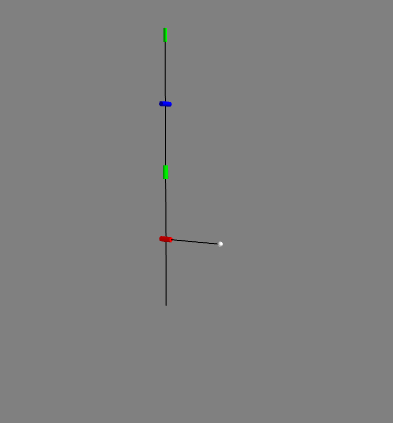

In [14]:
mbc = rbd.MultiBodyConfig(mb)
mbc.zero(mb)

# take the q vector
q = map(list, mbc.q)
print 'mbc.q:', q

# apply the forward kinematics
rbd.forwardKinematics(mb, mbc)

# draw the robot
from graph import MultiBodyViz
mbv = MultiBodyViz(mbg, mb)

mbv.addActors(viewer.scene)
mbv.display(mb, mbc)

viewer.scene.camera.focal_point = (0.145, 0.704, -0.185)
viewer.scene.camera.position = (3.77, 1.181, 4.474)

display()

mbc.q: [[], [1.5707963267948966], [-0.7853981633974483], [-1.5707963267948966], [0.5], [0.8660254037844387, 0.08451542547285165, 0.42257712736425823, 0.25354627641855493]]


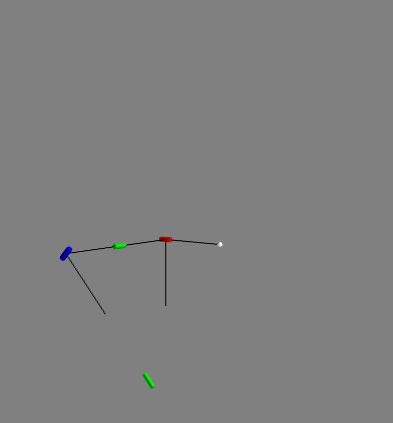

In [15]:
# update the q vector

quat = e.Quaterniond(np.pi/3., e.Vector3d(0.1, 0.5, 0.3).normalized())
q[1] = [np.pi/2.]
q[2] = [-np.pi/4.]
q[3] = [-np.pi/2.]
q[4] = [0.5]
q[5] = [quat.w(), quat.x(), quat.y(), quat.z()]
print 'mbc.q:', q

# you can also do like this
# mbc.q = [[], [np.pi/2.], [-np.pi/4.], [-np.pi/2.], [0.5], [quat.w(), quat.x(), quat.y(), quat.z()]]
mbc.q = q

# compute the forward kinematics
rbd.forwardKinematics(mb, mbc)

mbv.display(mb, mbc)
display()